In [1]:
#check if the dataset is balanced
import keras.datasets.fashion_mnist
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


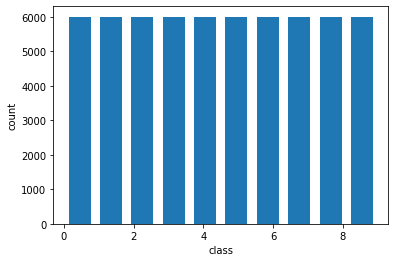

In [2]:
import matplotlib.pyplot as plt

# Adjust the bar widths here
plt.hist(train_labels, rwidth=0.7)
  
plt.ylabel("count")
plt.xlabel("class")
plt.show()

**CGAN for fashion mnist**
https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/




In [3]:
# Train a conditional gan on the fashion mnist dataset
import numpy
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y


# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, labels], y = generate_fake_samples(g_model, latent_dim, n_samples)
	X=numpy.array(X)
	print(numpy.shape(X))
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	pyplot.savefig('results_baseline/results_images_%03d.png' % (step+1))
	pyplot.close()
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, filename):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
	# save plot to file
	pyplot.savefig(filename)
	pyplot.close()

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# prepare lists for storing stats each iteration
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	e_d1_hist, e_d2_hist, e_g_hist, e_a1_hist, e_a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, d_acc1 = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, d_acc2 = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss and accuracy on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss,int(100*d_acc1), int(100*d_acc2)))
	 		# record history
			d1_hist.append(d_loss1)
			d2_hist.append(d_loss2)
			g_hist.append(g_loss)
			a1_hist.append(d_acc1)
			a2_hist.append(d_acc2)
		#after each epoch record history
		e_d1_hist.append(d_loss1)
		e_d2_hist.append(d_loss2)
		e_g_hist.append(g_loss)
		e_a1_hist.append(d_acc1)
		e_a2_hist.append(d_acc2)
		# evaluate the model performance every 'epoch'
		summarize_performance(i, g_model, latent_dim)
	plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist,'results_baseline/results_performance.png')
	plot_history(e_d1_hist, e_d2_hist, e_g_hist, e_a1_hist, e_a2_hist,'results_baseline/results_epochs.png')
	# save the generator model
	g_model.save('cgan_generator.h5')

# make folder for results
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>90, 161/468, d1=0.655, d2=0.160 g=2.166, a1=62, a2=100
>90, 162/468, d1=0.221, d2=0.699 g=1.824, a1=93, a2=62
>90, 163/468, d1=0.394, d2=0.352 g=3.132, a1=78, a2=84
>90, 164/468, d1=0.644, d2=0.150 g=1.870, a1=64, a2=100
>90, 165/468, d1=0.286, d2=0.574 g=1.813, a1=90, a2=67
>90, 166/468, d1=0.386, d2=0.572 g=2.304, a1=81, a2=71
>90, 167/468, d1=0.799, d2=0.465 g=1.815, a1=53, a2=73
>90, 168/468, d1=0.354, d2=0.354 g=2.421, a1=87, a2=92
>90, 169/468, d1=0.586, d2=0.266 g=2.110, a1=71, a2=96
>90, 170/468, d1=0.294, d2=0.593 g=1.981, a1=89, a2=67
>90, 171/468, d1=0.454, d2=0.498 g=2.261, a1=78, a2=78
>90, 172/468, d1=0.561, d2=0.240 g=2.019, a1=70, a2=95
>90, 173/468, d1=0.390, d2=0.684 g=2.266, a1=84, a2=57
>90, 174/468, d1=0.696, d2=0.345 g=2.026, a1=54, a2=90
>90, 175/468, d1=0.383, d2=0.714 g=2.003, a1=81, a2=56
>90, 176/468, d1=0.635, d2=0.342 g=1.876, a1=64, a2=93
>90, 177/468, d1=0.502, d2=0.615 g=2.049, a1=76, a2=64
>90, 178/468

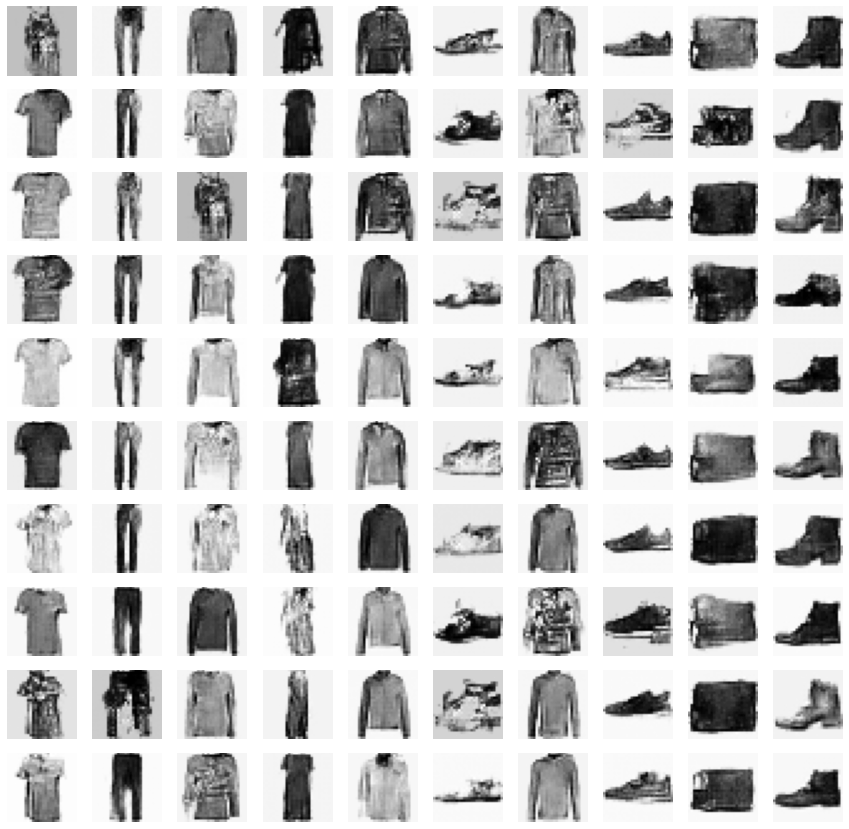

In [8]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	pyplot.figure(figsize=(15,15))
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 10000)
# specify labels
labels = asarray([x for _ in range(1000) for x in range(10)])
# generate images
cgan_gen_images  = model.predict([latent_points, labels])
# plot the result
save_plot(cgan_gen_images, 10)

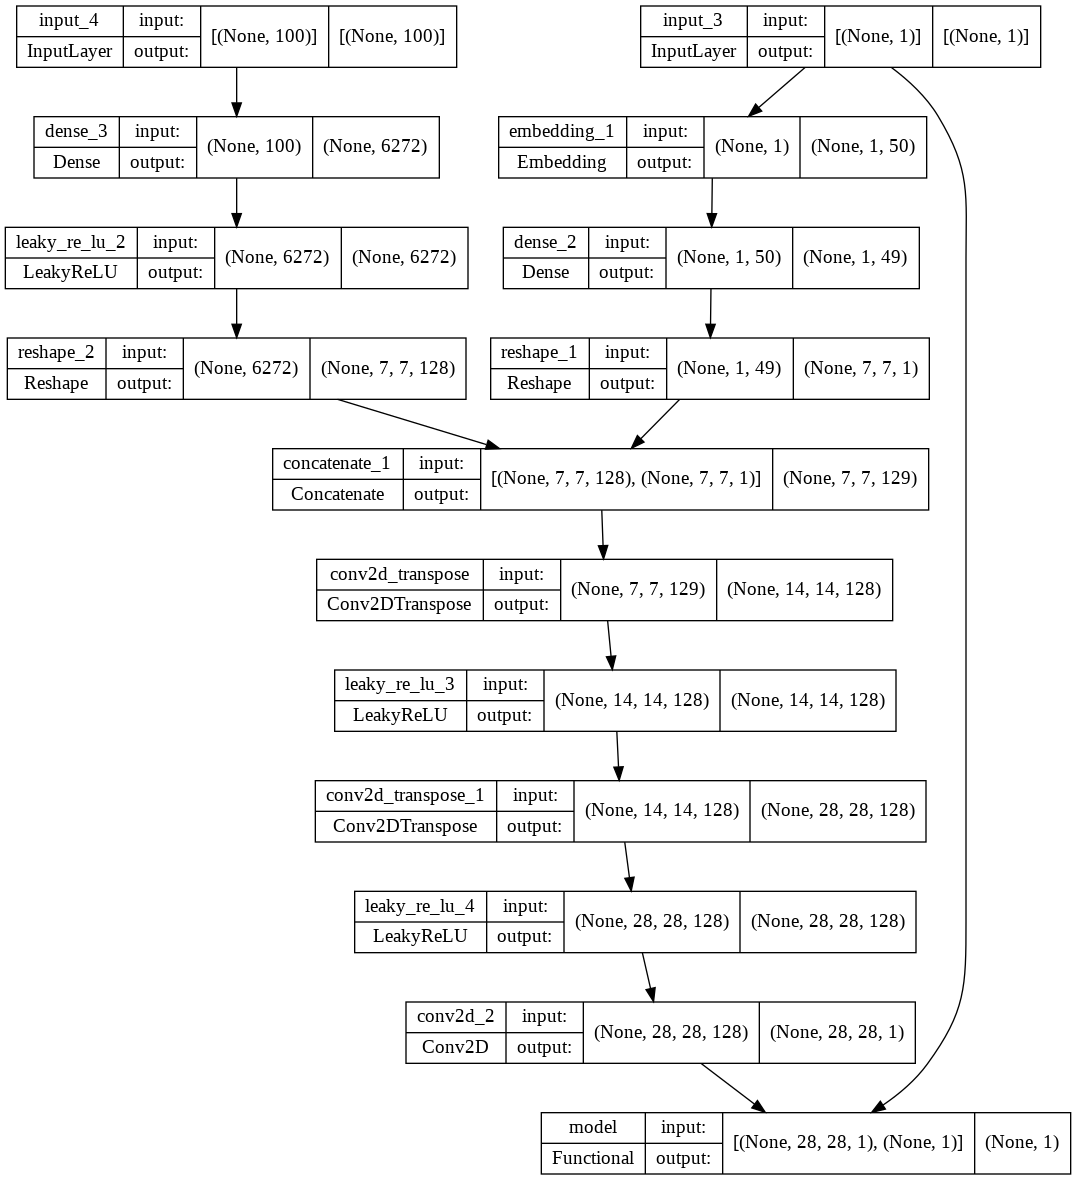

In [9]:
#arhitecture of the GAN model
from keras.utils.vis_utils import plot_model
plot_model(gan_model, to_file='cgan_model_plot.png', show_shapes=True, show_layer_names=True)

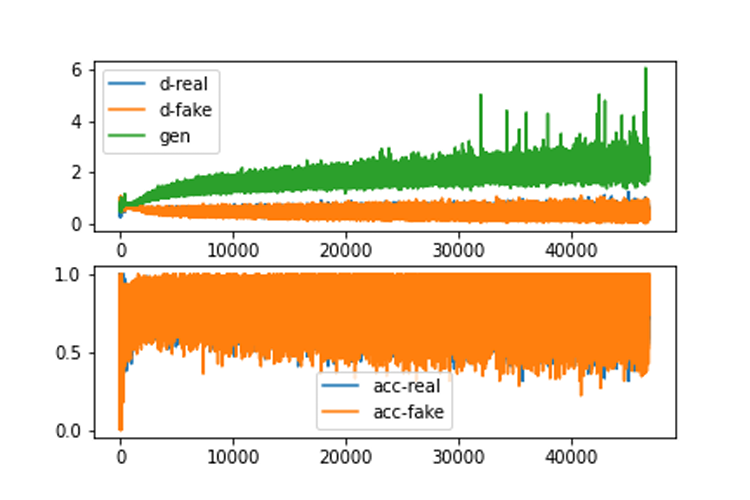

In [10]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

img = cv2.imread('results_baseline/results_performance.png')
res = cv2.resize(img, dsize=(750, 500), interpolation=cv2.INTER_CUBIC)
cv2_imshow(res)
#cv2.waitKey(0)

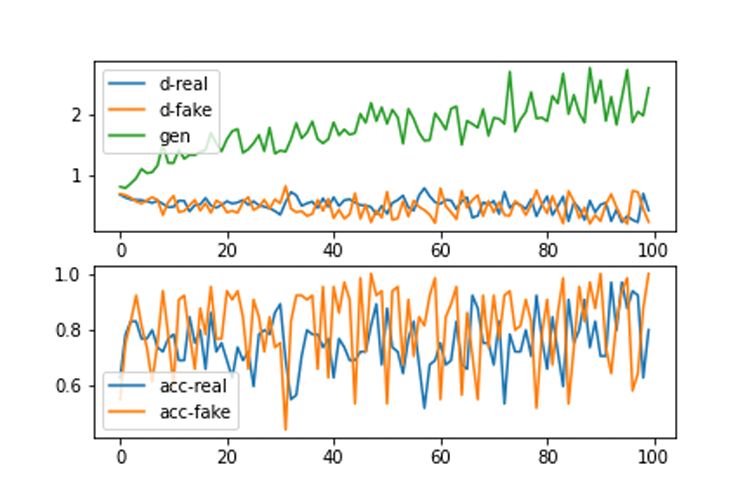

In [11]:
img = cv2.imread('results_baseline/results_epochs.png')
res = cv2.resize(img, dsize=(750, 500), interpolation=cv2.INTER_CUBIC)
cv2_imshow(res)


In [12]:
#print(cgan_gen_images[0])

In [13]:
cgan_gen_images.shape

(10000, 28, 28, 1)

In [14]:
#denormalization of the generated images
cgan_gen_images = cgan_gen_images * 255
cgan_gen_images = cgan_gen_images.astype('uint8')

In [15]:
#print(cgan_gen_images[0])

**CNN model**
https://github.com/cloudxlab/ml/blob/master/projects/Fashion-MNIST/Fashion-MNIST-DL-Keras.ipynb

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

In [17]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [18]:
#print(train_images[0])

In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [20]:
train_images.shape
train_labels.shape
test_images.shape
test_labels.shape

(10000,)

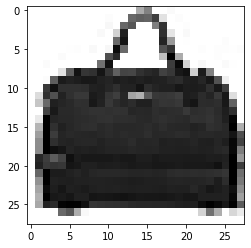

In [23]:
plt.figure()
plt.imshow(np.squeeze(train_images[220]), cmap='gray_r')

In [24]:
train_labels[220]

8

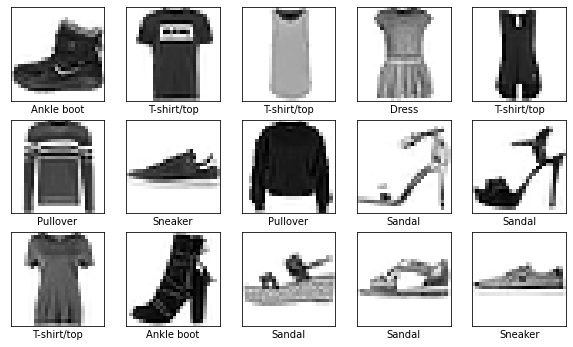

In [25]:
#display images from the 10 different classes
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [26]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [27]:
# convert from ints to floats
train_images= train_images.astype('float32')
test_images= test_images.astype('float32')
# scale from [0,255] to [0,1]
train_images_norm = train_images / 255.0 
test_images_norm = test_images / 255.0

In [28]:
conv1 = layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1) )
conv2 = layers.Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(l=0.01))
conv3 = layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=regularizers.l2(l=0.01))
max_pool_1 = layers.MaxPooling2D((2,2))

#Creating second Max. Pooling Layer
max_pool_2 = layers.MaxPooling2D((2,2))

#Creating third Max. Pooling Layer
max_pool_3 = layers.MaxPooling2D((2,2))
flat_layer = layers.Flatten()
fc = layers.Dense(128, activation='relu')
output = layers.Dense(10, 'softmax')

# Creating second dropout layer (for the second Conv. layer 'conv2')
drop_2 = keras.layers.Dropout(0.5)
# Creating third dropout layer (for the third Conv. layer 'conv3')
drop_3 = keras.layers.Dropout(0.5)

In [29]:
new_model = models.Sequential()

new_model.add(conv1)
# No Pooling Layer and Dropout layer for first Convolutional layer 'conv1'
new_model.add(conv2)
new_model.add(max_pool_2)
new_model.add(drop_2)
new_model.add(conv3)
new_model.add(max_pool_3)
new_model.add(drop_3)
new_model.add(flat_layer)
new_model.add(fc)
new_model.add(output)

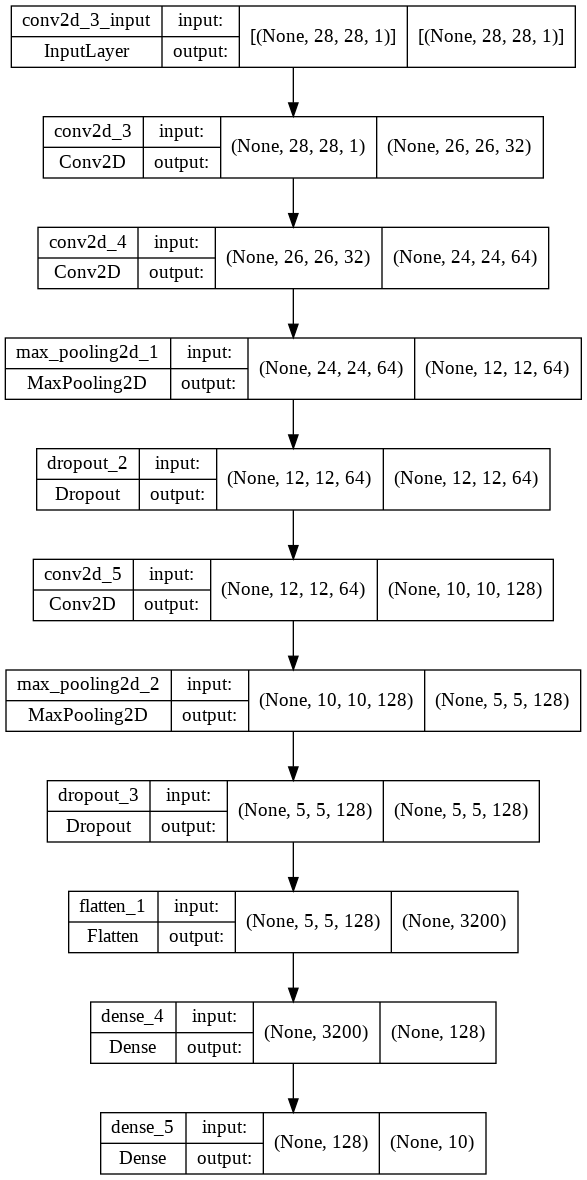

In [30]:
#CNN model architecture
from keras.utils.vis_utils import plot_model
plot_model(new_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
#compiling the model
new_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history1=new_model.fit(train_images_norm, train_labels, epochs=100, batch_size=256, shuffle=True, validation_split=0.1)

Epoch 1/100
211/211 [==============================] - 9s 36ms/step - loss: 1.0814 - accuracy: 0.7190 - val_loss: 0.5995 - val_accuracy: 0.8257
Epoch 2/100
211/211 [==============================] - 7s 32ms/step - loss: 0.5907 - accuracy: 0.8209 - val_loss: 0.5047 - val_accuracy: 0.8493
Epoch 3/100
211/211 [==============================] - 7s 33ms/step - loss: 0.5159 - accuracy: 0.8432 - val_loss: 0.4502 - val_accuracy: 0.8648
Epoch 4/100
211/211 [==============================] - 7s 32ms/step - loss: 0.4833 - accuracy: 0.8531 - val_loss: 0.4503 - val_accuracy: 0.8667
Epoch 5/100
211/211 [==============================] - 7s 32ms/step - loss: 0.4587 - accuracy: 0.8603 - val_loss: 0.4258 - val_accuracy: 0.8735
Epoch 6/100
211/211 [==============================] - 7s 32ms/step - loss: 0.4405 - accuracy: 0.8672 - val_loss: 0.4003 - val_accuracy: 0.8818
Epoch 7/100
211/211 [==============================] - 7s 32ms/step - loss: 0.4264 - accuracy: 0.8710 - val_loss: 0.3894 - val_accuracy:

In [35]:
# we are using the normalized input test data
test_loss, test_accuracy = new_model.evaluate(test_images_norm, test_labels)
print('accuracy',test_accuracy, 'loss',test_loss )

313/313 [==============================] - 2s 6ms/step - loss: 0.3032 - accuracy: 0.9166
accuracy 0.9165999889373779 loss 0.30321204662323


In [36]:
#model is saved to use to calculate the IS and FID scores
new_model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


In [37]:
from tensorflow import keras
new_model1 = keras.models.load_model('cnn_model')

In [38]:
print(np.shape(np.reshape(test_images_norm[1],(1,28,28,1))))
print(np.shape(test_images_norm))

(1, 28, 28, 1)
(10000, 28, 28, 1)


In [39]:
print('predicted:',np.argmax(new_model1.predict(np.reshape(test_images_norm[1],(1,28,28,1)))))
print('actual:',test_labels[1])

predicted: 2
actual: 2


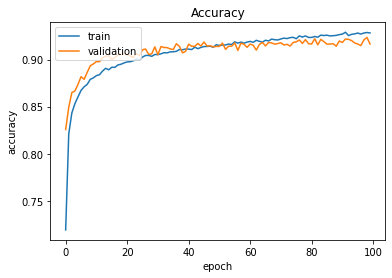

In [40]:
#plot for the training and validation accuracy of CNN
plt.plot(history1.history["accuracy"])
plt.plot(history1.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

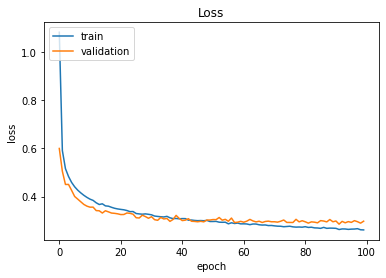

In [41]:
#plot for the training and validation losses of CNN
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
predicted_test_labels = new_model1.predict(test_images_norm)
predicted_test_labels.shape

(10000, 10)

In [43]:
predicted_test_labels_index = np.argmax(predicted_test_labels[88])
predicted_test_labels_index

0

In [44]:
test_labels[88]

0

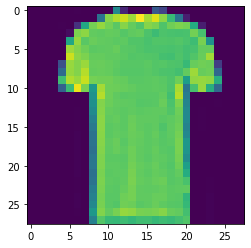

In [45]:
plt.figure()
plt.imshow(np.squeeze(test_images[88]))

**CNN accuracy on generated images**

In [47]:
# convert from ints to floats
cgan_images= cgan_gen_images.astype('float32')
cgan_images = cgan_images / 255.0

label index: 4 class name: Coat
[0 1 2 3 4 5 6 7 8 9]
1000


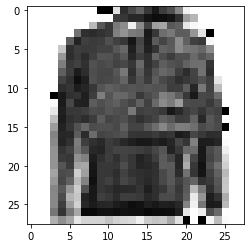

In [62]:
plt.figure()
ind=4
plt.imshow(np.squeeze(cgan_images[ind]), cmap='gray_r')
print('label index:',labels[ind],'class name:',class_names[labels[ind]])
print(np.unique(labels))
print((labels==8).sum())
#print(np.where(labels==8))

In [51]:
#accuracy and loss of CNN on the generated images of CGAN
gen_loss, gen_accuracy = new_model.evaluate(cgan_images, labels)
print('accuracy',gen_accuracy, 'loss',gen_loss )

313/313 [==============================] - 2s 7ms/step - loss: 0.6714 - accuracy: 0.7864
accuracy 0.7864000201225281 loss 0.6714329123497009


**loading dataset for evaluation**

In [52]:
fashion_mnist = keras.datasets.fashion_mnist
(tr_images, tr_labels), (te_images, te_labels) = fashion_mnist.load_data()

In [53]:
print(np.shape(cgan_gen_images))
print(np.shape(te_images))

(10000, 28, 28, 1)
(10000, 28, 28)


**Inception Score**

---



In [66]:
# calculate inception score for fashionmnist 
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = image.reshape(new_shape)
		new_image = new_image.astype('float32')
		new_image = new_image / 255.0
		# store
		images_list.append(new_image)
	return asarray(images_list)


def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load CNN model
	model = keras.models.load_model('cnn_model')
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		#subset = subset.astype('float32')
		# scale images to the required size
		# pre-process images, scale to [0,1]
		subset = scale_images(subset, (28,28,1))
		# predict p(y|x)
		p_yx = model.predict(subset)
		#print(p_yx)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std, scores


n_split = [i for i in range(10)]
images = cgan_gen_images
print('loaded', images.shape)
# calculate inception score
is_avg, is_std, gen_scores = calculate_inception_score(images)
print('score for generated images', is_avg, is_std)

images2 = te_images
print('loaded', images2.shape)
# calculate inception score
is_avg, is_std, test_scores = calculate_inception_score(images2)
print('score for test real images', is_avg, is_std)

images3 = tr_images[0:10000]
print('loaded', images3.shape)
# calculate inception score
is_avg, is_std, train_scores = calculate_inception_score(images3)
print('score for train real images', is_avg, is_std)

loaded (10000, 28, 28, 1)
score for generated images 5.693971 0.091410086
loaded (10000, 28, 28)
score for test real images 8.022054 0.06370657
loaded (10000, 28, 28)
score for train real images 8.1542845 0.10844568


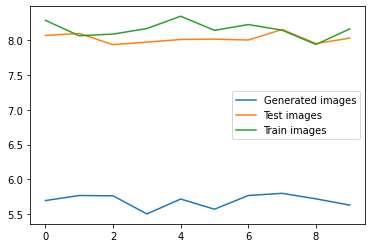

In [67]:
import matplotlib.pyplot as plt
  
# plot graph for IS scores for generated,test, train images
plt.plot(n_split, gen_scores, label = "Generated images")
plt.plot(n_split, test_scores, label = "Test images")
plt.plot(n_split, train_scores, label = "Train images")
plt.legend()
plt.show()

**Frechet Inception Distance**
https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [69]:
#calculating the frechet inception distance on fashionMNIST
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.layers.pooling import GlobalAveragePooling2D

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = image.reshape(new_shape)
		new_image = new_image.astype('float32')
		new_image = new_image / 255.0
		# store
		images_list.append(new_image)
	return asarray(images_list)


# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the CNN model
model = keras.models.load_model('cnn_model')
#last output layer removed and the activations of second last layer used
output = model.layers[-2].output
modele = Model(inputs = model.input, outputs = output)
# take the generated images
images1 = cgan_gen_images
print('loaded', images1.shape)

#real images(train and test set)
images2 = te_images[0:10000]
images3 = tr_images[0:10000]
# FID generated images with itself
fid = calculate_fid(modele, images1, images1)
print('FID (same): %.3f' % fid)
# FID between generated and test set
fid = calculate_fid(modele, images1, images2)
print('FID (different gen & test): %.3f' % fid)
# FID between generated and train set
fid = calculate_fid(modele, images1, images3)
print('FID (different gen & train): %.3f' % fid)
# FID between train and test set
fid = calculate_fid(modele, images2, images3)
print('FID (different test & train): %.3f' % fid)


loaded (10000, 28, 28, 1)
FID (same): -0.000
FID (different gen & test): 466745.360
FID (different gen & train): 477378.367
FID (different test & train): 3809.409
